In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import json
import plotly.express as px

In [2]:
df = pd.read_excel('../data/raw/farm_site_boundary.xlsx')

In [3]:
def string_to_polygon(s):
    # Replace single quotes with double quotes for valid JSON format
    s = s.replace("'", '"')
    # Turn the string into a list of point dictionaries
    points_list = eval(s)
    # Create a Polygon object from the list of point dictionaries
    polygon = Polygon([(point['lng'], point['lat']) for point in points_list])
    return polygon

In [4]:
df['polygon_geometry'] = df['location_grid_points'].apply(string_to_polygon)
df['point_geometry'] = [Point(x, y) for x, y in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry='point_geometry')

In [5]:
gdf.crs = "EPSG:4326"
gdf.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919)
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613)
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464)
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513)
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653)


In [6]:
slc_polygons = gpd.read_file("../data/external/slc")
slc_polygons = slc_polygons.set_crs('EPSG:4269', inplace=True)
slc_polygons = slc_polygons.to_crs('EPSG:4326')
slc_polygons

,AREA,PERIMETER,POLY_ID,ECO_ID,geometry
0,1.376666,6.159230,14003,14,"POLYGON ((-73.74820 83.60566, -72.61377 83.626..."
1,1.580340,9.611541,14002,14,"POLYGON ((-70.91842 83.63315, -69.65201 83.612..."
2,0.932502,5.332157,14004,14,"POLYGON ((-75.75444 83.56109, -74.13673 83.597..."
3,2.408007,13.902721,14005,14,"POLYGON ((-77.61654 83.51138, -76.16966 83.550..."
4,3.511283,27.056163,14001,14,"POLYGON ((-67.62450 83.54608, -65.74776 83.467..."
...,...,...,...,...,...
12348,0.011228,1.038751,572002,572,"POLYGON ((-82.62274 42.09282, -82.62270 42.093..."
12349,0.028866,0.843499,572004,572,"POLYGON ((-82.75051 42.03226, -82.74742 42.031..."
12350,0.019782,0.745984,572006,572,"POLYGON ((-82.86602 42.03530, -82.86598 42.033..."
12351,0.087583,1.234050,572005,572,"POLYGON ((-82.57620 41.88860, -82.57074 41.950..."


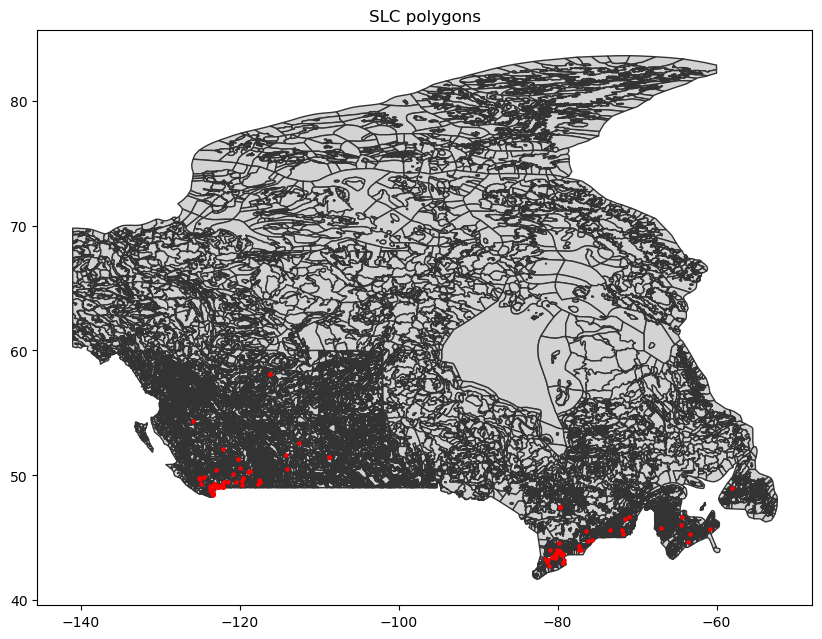

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
slc_polygons.plot(ax=ax, edgecolor="0.2", color='lightgrey')
# ax.set_aspect('equal')
gdf.set_geometry('point_geometry', inplace=True)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("SLC polygons")
plt.show()

In [8]:
farm_polygons = gpd.sjoin(gdf, 
                          slc_polygons[["POLY_ID", "ECO_ID", "geometry"]],
                          how='left', 
                          predicate='within'
                         ).drop(columns=['index_right'])
farm_polygons.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,POLY_ID,ECO_ID
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),959010,959
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),959010,959
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),562002,562
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),458007,458
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),540095,540


In [9]:
climate = pd.read_csv("../data/raw/Holos/ecodistrict_to_ecozone_mapping.csv")
climate.head()

,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,358,Boreal Shield West,Manitoba,348,453,0.00,Brown Chernozem,Coarse
1,358,Boreal Shield West,Saskatchewan,348,453,0.00,Brown Chernozem,Coarse
2,371,Boreal Shield West,Manitoba,376,581,0.33,Black/Gray Chernozem,Fine
3,371,Boreal Shield West,Ontario,376,581,0.33,Eastern Canada,Fine
4,375,Boreal Shield West,Manitoba,411,579,0.33,Black/Gray Chernozem,Fine


In [10]:
holos_ecodistrict = climate["Ecodistrict"].unique().tolist()
farms_ecodistrict = farm_polygons["ECO_ID"].unique().tolist()

all_elements_contained = set(farms_ecodistrict).issubset(holos_ecodistrict)
print(all_elements_contained)

True


In [11]:
provinces = gpd.read_file("../data/external/provinces_shp")
provinces = provinces.to_crs("EPSG:4326") 
provinces.head()

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((-57.40256 54.14965, -57.38429 ..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((-61.98300 46.45775, -61.98136 ..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((-61.90233 45.87878, -61.90057 ..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((-64.80155 47.80365, -64.80155 ..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((-58.64703 51.20816, -58.63991 ..."


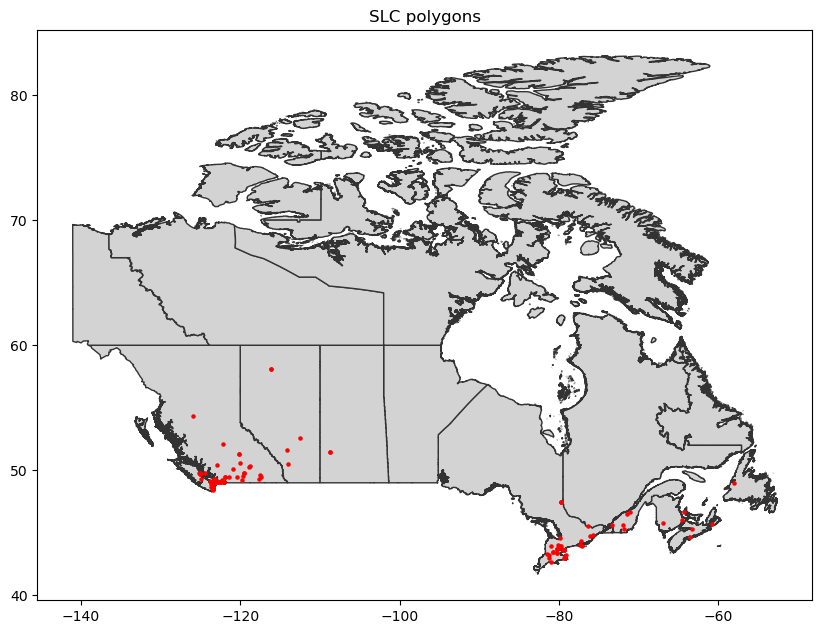

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
provinces.plot(ax=ax, edgecolor="0.2", color='lightgrey')
# ax.set_aspect('equal')
gdf.set_geometry('point_geometry', inplace=True)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("SLC polygons")
plt.show()

In [13]:
# Add province column 
farm_polygons = farm_polygons.to_crs("EPSG:4326") 
farm_polygons.set_geometry('point_geometry', inplace=True)
farm_eco_prov = gpd.sjoin(farm_polygons,
                          provinces[["PRENAME", "geometry"]], 
                          how='left', 
                          predicate='intersects'
                          ).drop(columns=['index_right'])

In [14]:
farm_eco_prov.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,POLY_ID,ECO_ID,PRENAME
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),959010,959,British Columbia
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),959010,959,British Columbia
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),562002,562,Ontario
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),458007,458,Newfoundland and Labrador
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),540095,540,Quebec


In [15]:
farm_prov = farm_eco_prov["PRENAME"].unique().tolist()
climate_prov = climate["Province"].unique().tolist()

all_province_contained = set(climate_prov).issubset(farm_prov)
print(all_elements_contained)

True


In [16]:
farm_ecoid_climate = pd.merge(farm_eco_prov, climate,  
                              how='left', 
                              left_on=['ECO_ID','PRENAME'], 
                              right_on = ['Ecodistrict','Province'])


In [17]:
farm_ecoid_climate.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,...,ECO_ID,PRENAME,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),...,959,British Columbia,959,Pacific Maritime,British Columbia,480,506,6.53,Brown Chernozem,Medium
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),...,959,British Columbia,959,Pacific Maritime,British Columbia,480,506,6.53,Brown Chernozem,Medium
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),...,562,Ontario,562,Mixedwood Plains,Ontario,461,586,2.03,Eastern Canada,Medium
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),...,458,Newfoundland and Labrador,458,Boreal Shield East,Newfoundland and Labrador,621,407,0.00,Eastern Canada,Medium
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),...,540,Quebec,540,Mixedwood Plains,Quebec,652,556,11.71,Eastern Canada,Coarse


In [18]:
farm_ecoid_climate.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   farm_id               123 non-null    object  
 1   country_name          123 non-null    object  
 2   latitude              123 non-null    float64 
 3   longitude             123 non-null    float64 
 4   location_id           123 non-null    object  
 5   type                  123 non-null    object  
 6   location_area_m2      123 non-null    float64 
 7   location_grid_points  123 non-null    object  
 8   polygon_geometry      123 non-null    object  
 9   point_geometry        123 non-null    geometry
 10  POLY_ID               123 non-null    int64   
 11  ECO_ID                123 non-null    int64   
 12  PRENAME               123 non-null    object  
 13  Ecodistrict           123 non-null    int64   
 14  Ecozone               123 non-null    object  
 15